### Stochastic Differential Equation (SDE) with Jump Processes

This simulation models the concentration dynamics in a Continuous Stirred-Tank Reactor (CSTR) using a Stochastic Differential Equation (SDE) with jump processes. The system accounts for both continuous diffusion and discrete jumps, representing random perturbations.

The SDE is defined as:

$$dC = \left( \frac{F}{V}(C_{in} - C) - kC \right) dt + \sigma dW + J$$

Where:
- $C$: Concentration in the reactor
- $F$: Flow rate
- $V$: Reactor volume
- $C_{in}$: Inlet concentration
- $k$: Reaction rate constant
- $\sigma$: Diffusion coefficient
- $W$: Wiener process (Brownian motion)
- $J$: Jump term, occurring with intensity $\lambda_{jump}$ and magnitude $\vert J \vert$

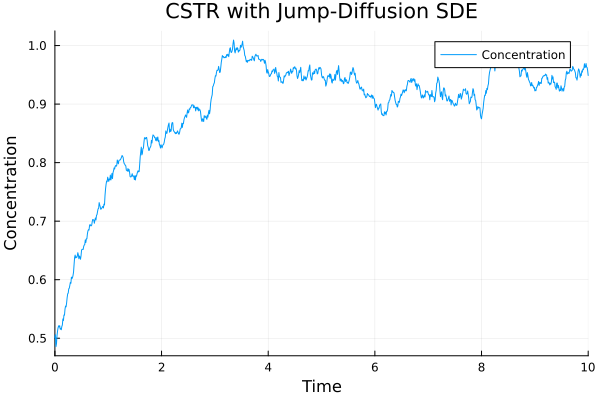

In [4]:
using DifferentialEquations
using Random
using Plots

# Parameters for the CSTR
k = 0.1  # Reaction rate constant
F = 1.0  # Flow rate
V = 1.0  # Volume of the reactor
C_in = 1.0  # Inlet concentration
sigma = 0.05  # Diffusion coefficient
lambda_jump = 0.1  # Jump intensity
jump_magnitude = 0.5  # Magnitude of jumps

# Time parameters
T = 10.0  # Total simulation time
dt = 0.01  # Time step

# Define the SDE function
function drift!(du, u, p, t)
    du[1] = (F / V) * (C_in - u[1]) - k * u[1]
end

function diffusion!(du, u, p, t)
    du[1] = sigma
end

# Define the jump process
function jump!(integrator)
    integrator.u[1] += jump_magnitude
end

# Define the condition for the jump
function jump_condition(u, t, integrator)
    rand() < lambda_jump * dt
end

# Initial condition
u0 = [0.5]

# Time span
tspan = (0.0, T)

# Problem definition
prob = SDEProblem(drift!, diffusion!, u0, tspan)

# Add the jump process
jump = DiscreteCallback(jump_condition, jump!)
jump_prob = SDEProblem(drift!, diffusion!, u0, tspan, callback=jump)

# Solve the problem
sol = solve(jump_prob, EM(), dt=dt)

# Plot the results
plot(sol, label="Concentration", xlabel="Time", ylabel="Concentration", title="CSTR with Jump-Diffusion SDE", legend=:topright, grid=true)